<a href="https://colab.research.google.com/github/wgsbt4859/u-net/blob/main/u_net_submit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Netの実装

https://arxiv.org/pdf/1505.04597.pdf

- 特徴マップそのものを転送 (Decoderでconcat)
    - concatすることで、位置情報を正確に渡し、学習速度/安定性が向上
- アップサンプリングには転置畳み込みを使用

現在でも広く用いられている。

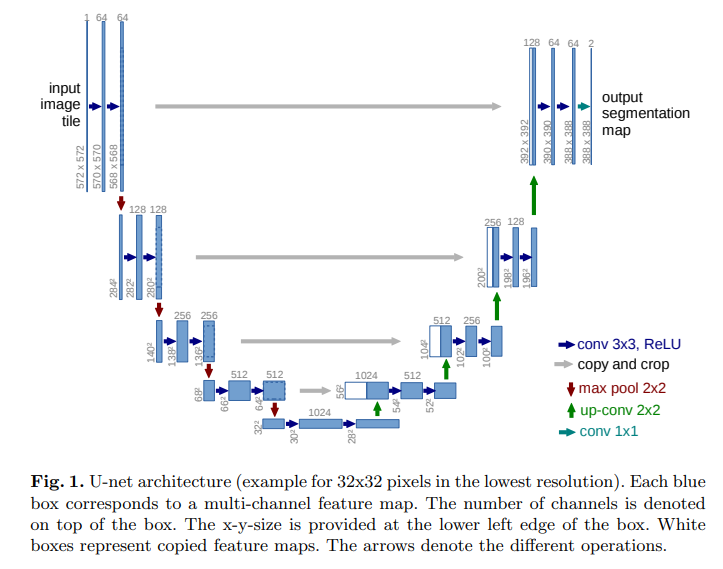

In [ ]:
#モジュールのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from PIL import Image

# 進捗状況を表示するライブラリ
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision import models

%matplotlib inline


In [1]:
"""
ラベル

0: sky, 1: building, 2: pole, 3: road_masking
4: road, 5: tree, 6: signsymbol, 7: fence
8: car, 9: pedestrian, 10: bycyclist, 11: unlabeled
"""

'\nラベル\n\n0: sky, 1: building, 2: pole, 3: road_masking\n4: road, 5: tree, 6: signsymbol, 7: fence\n8: car, 9: pedestrian, 10: bycyclist, 11: unlabeled\n'

In [ ]:
# データセットの読み込み
# images, labelsで1対1で対応するように、sortした上で読み込む

root = "/content/cv-dataset/segmentation"

images = sorted(glob(root + "/train_images/*.png"))
labels = sorted(glob(root + "/train_annotations/*.png"))

In [ ]:
len(images), len(labels)

(367, 367)

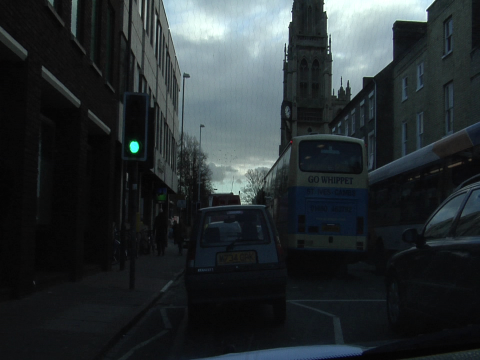

In [ ]:
# サンプルとして1枚を確認
img = Image.open(images[0])
img

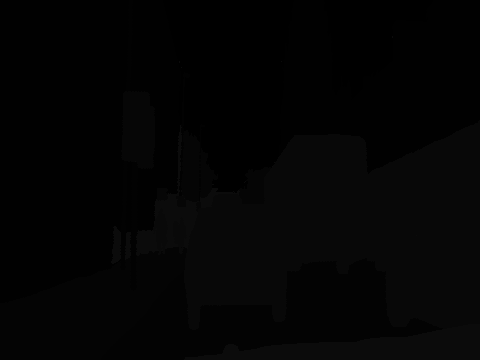

In [ ]:
# 上図に対応するマスク画像は、
label = Image.open(labels[0])
label

## マスク画像のカラーリング

In [ ]:
# サンプルラベル(label)のサイズを確認
label = np.array(label)
label.shape

(360, 480)

In [ ]:
# カラー画像にするため、3チャネルを追加し、同じH, W分の0を持つテンソルを作成
color_mask = np.zeros((label.shape[0], label.shape[1], 3))
color_mask.shape

(360, 480, 3)

In [ ]:
# クラス分の色を準備
n_classes = 12
colors = sns.color_palette(n_colors=n_classes, palette="hls")
colors

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.6312, 0.33999999999999997),
 (0.8287999999999999, 0.86, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.33999999999999997, 0.86, 0.6312),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.5688000000000001, 0.86),
 (0.3712, 0.33999999999999997, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.8287999999999999),
 (0.86, 0.33999999999999997, 0.5688000000000001)]

In [ ]:
# それぞれのピクセルに、色を割り振っていく

for c in range(n_classes):
    c_bool = (label == c)
    color_mask[:, :, 0] += (c_bool * colors[c][0])
    color_mask[:, :, 1] += (c_bool * colors[c][1])
    color_mask[:, :, 2] += (c_bool * colors[c][2])

color_mask

array([[[0.86  , 0.6312, 0.34  ],
        [0.86  , 0.6312, 0.34  ],
        [0.86  , 0.6312, 0.34  ],
        ...,
        [0.86  , 0.6312, 0.34  ],
        [0.86  , 0.6312, 0.34  ],
        [0.86  , 0.6312, 0.34  ]],

       [[0.86  , 0.6312, 0.34  ],
        [0.86  , 0.6312, 0.34  ],
        [0.86  , 0.6312, 0.34  ],
        ...,
        [0.86  , 0.6312, 0.34  ],
        [0.86  , 0.6312, 0.34  ],
        [0.86  , 0.6312, 0.34  ]],

       [[0.86  , 0.6312, 0.34  ],
        [0.86  , 0.6312, 0.34  ],
        [0.86  , 0.6312, 0.34  ],
        ...,
        [0.86  , 0.6312, 0.34  ],
        [0.86  , 0.6312, 0.34  ],
        [0.86  , 0.6312, 0.34  ]],

       ...,

       [[0.34  , 0.86  , 0.3712],
        [0.34  , 0.86  , 0.3712],
        [0.34  , 0.86  , 0.3712],
        ...,
        [0.86  , 0.34  , 0.5688],
        [0.86  , 0.34  , 0.5688],
        [0.86  , 0.34  , 0.5688]],

       [[0.34  , 0.86  , 0.3712],
        [0.34  , 0.86  , 0.3712],
        [0.34  , 0.86  , 0.3712],
        .

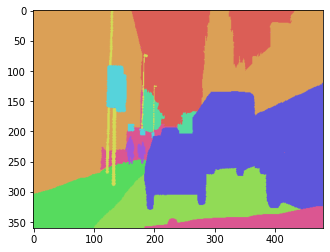

In [ ]:
plt.imshow(color_mask)

In [ ]:
# 以上をgive_color関数でまとめると下記

def give_color(img, n_classes):
  colors = sns.color_palette(n_colors=n_classes)
  color_mask = np.zeros((img.shape[0], img.shape[1], 3))
  for c in range(n_classes):
    c_bool = (img == c)
    color_mask[:, :, 0] += (c_bool * colors[c][0])
    color_mask[:, :, 1] += (c_bool * colors[c][1])
    color_mask[:, :, 2] += (c_bool * colors[c][2])
  return color_mask

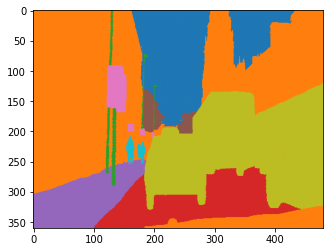

In [ ]:
color_mask = give_color(label, 12)

plt.imshow(color_mask)

## Dataloaderの定義

In [ ]:
# 以上をまとめたもの

class CreateDataset(torch.utils.data.Dataset):

    def __init__(self, mode='train', root='/segmentation'):

        self.images = sorted(glob(root + f'/{mode}_images/*.png'))
        self.labels = sorted(glob(root + f'/{mode}_annotations/*.png'))
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        #入力画像の読み込み
        image_path = self.images[idx]
        image = Image.open(image_path).resize((224, 224))
        image = self.transform(image)

        #マスク画像の読み込み
        label_path = self.labels[idx]
        label = Image.open(label_path).resize((224, 224),  resample=Image.NEAREST)
        label = torch.tensor(np.array(label), dtype=torch.int64)

        return image, label

root = "../input/segmentation-dataset-1"
train = CreateDataset(mode='train', root=root)
val = CreateDataset(mode='val', root=root)

batch_size = 8

train_loader = torch.utils.data.DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
val_loader = torch.utils.data.DataLoader(
    val,
    batch_size=batch_size
)

In [ ]:
!pip install -q pytorch-lightning

In [ ]:
!pip install -q torchmetrics

In [ ]:
!pip install -q torchsummary

In [ ]:
import pytorch_lightning as pl

In [ ]:
import torchmetrics
from torchmetrics.functional import accuracy

In [ ]:
# Down samplingの実装
# 2回畳み込み → Max pooling というフローを「Down」としてクラス化する。

# 2回畳み込み処理のクラス

class DoubleConv(pl.LightningModule):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.double_conv(x)

class Down(pl.LightningModule):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.down(x)

In [ ]:
# up samplingのクラス化 (Up)
# 画像サイズを2倍 (転置畳み込み)にし、2回畳み込み。2回畳み込みは上記でDoubleConvクラスとして定義済。
# Up層で出力するチャネル数を1/2にするため、転置畳み込みの際に出力チャネル数を入力チャネル数の1/2とする。
# Encoderからの出力とDecoderからの出力をconcatで結合する。その際、入力サイズが異る場合もあるため、F.padでサイズ調整をする。


class Up(pl.LightningModule):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        
        """
        x1: Decoderからの出力
        x2: Encoderからの出力
        """

        x1 = self.up(x1)

        # x1, x2のサイズ差を格納
        # x1の形状: (batch_size, c, h, w)
        diff_h = torch.tensor([x2.size()[2] - x1.size()[2]])
        diff_w = torch.tensor([x2.size()[3] - x1.size()[3]])

        # x1を0でpaddingし、x2のh, wとサイズを揃える
        # F.pad(<paddingしたい対象>, [left, right, top, bottom])
        
        x1 = F.pad(x1, [diff_h // 2, diff_h - diff_h // 2, diff_w // 2, diff_w - diff_w // 2])

        x = torch.cat([x2, x1], dim=1)

        return self.conv(x)

## UNetクラスの定義

In [ ]:
class UNet(pl.LightningModule):

    def __init__(self, in_channels, hidden_size, n_classes):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes

        """
        Encoder

        """

        self.inconv = DoubleConv(in_channels, hidden_size)

        self.down1 = Down(hidden_size, hidden_size*2)
        self.down2 = Down(hidden_size*2, hidden_size*4)
        self.down3 = Down(hidden_size*4, hidden_size*8)
        self.down4 = Down(hidden_size*8, hidden_size*16)

        """
        Decoder

        Upクラスのin_channelsは、encoderおよびdecoderからのテンソルをconcatした後のチャネル数 (すなわち、decoder入力時の2倍のチャネル数)
        で定義している

        """
        
        
        self.up1 = Up_original(hidden_size*16, hidden_size*8)
        self.up2 = Up_original(hidden_size*8, hidden_size*4)
        self.up3 = Up_original(hidden_size*4, hidden_size*2)
        self.up4 = Up_original(hidden_size*2, hidden_size)
        
        self.outconv = nn.Conv2d(hidden_size, n_classes, kernel_size=1)

    def forward(self, x):
        
        # Encoder

        x1 = self.inconv(x) # ch: 3   -> ch: 64,  size: 224 * 224 -> 224 * 224
        x2 = self.down1(x1) # ch: 64  -> ch: 128, size: 224 * 224 -> 112 * 112
        x3 = self.down2(x2) # ch: 128 -> ch: 256, size: 112 * 112 -> 56 * 56
        x4 = self.down3(x3) # ch: 256 -> ch: 512, size: 56 * 56 -> 28 * 28
        x5 = self.down4(x4) # ch: 512 -> ch: 1024, size: 28 * 28 -> 14 * 14

        # Decoder

        x = self.up1(x5, x4) # ch: 1024 -> ch: 512, size: 14 * 14 -> 28 * 28
        x = self.up2(x, x3)  # ch: 512 -> ch: 256, size: 28 * 28 -> 56 * 56
        x = self.up3(x, x2)  # ch: 256 -> ch: 128,  size: 56 * 56 -> 112 * 112
        x = self.up4(x, x1)  # ch: 128  -> ch: 64,  size: 112 * 112 -> 224 * 224

        return self.outconv(x) # ch: 64  -> ch: 12,  size: 224 * 224 -> 224 * 224

    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        self.log("train_acc", accuracy(y.softmax(dim=1), t), on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log("val_loss", loss, on_step=True, on_epoch=True)
        self.log("val_acc", accuracy(y.softmax(dim=1), t), on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

In [ ]:
from torchsummary import summary

net = UNet(in_channels=3, hidden_size=64, n_classes=12)
summary(net, (3, 224, 224), device="cpu")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
        DoubleConv-7         [-1, 64, 224, 224]               0
         MaxPool2d-8         [-1, 64, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]          73,856
      BatchNorm2d-10        [-1, 128, 112, 112]             256
             ReLU-11        [-1, 128, 112, 112]               0
           Conv2d-12        [-1, 128, 112, 112]         147,584
      BatchNorm2d-13        [-1, 128, 112, 112]             256
             ReLU-14        [-1, 128, 1

In [ ]:
# 学習実行
pl.seed_everything(0)
net = UNet(in_channels=3, hidden_size=64, n_classes=12)
trainer = pl.Trainer(max_epochs=100, gpus=1)
trainer.fit(net, train_loader, val_loader)

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | inconv  | DoubleConv | 39.0 K
1 | down1   | Down       |

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
trainer.callback_metrics

{'train_loss': tensor(0.1013),
 'train_loss_step': tensor(0.0962),
 'train_acc': tensor(0.9631),
 'train_acc_step': tensor(0.9647),
 'val_loss': tensor(0.3909),
 'val_loss_epoch': tensor(0.3909),
 'val_acc': tensor(0.8963),
 'val_acc_epoch': tensor(0.8963),
 'train_loss_epoch': tensor(0.1013),
 'train_acc_epoch': tensor(0.9631)}

In [ ]:
# ピクセルごとには、validation accuracy: 0.91

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
# modelの保存
torch.save(net.state_dict(), "UNet_model.pt")

# Modelの読み込み

クラスごとにピクセル数の偏りが大きい → ピクセル数全体の正解率を基準にすると、ピクセル数の多いクラスの正解率が高ければ、全体の正解率も高く出てしまう。

→ Intersection over Union (IoU) (positive / trueの和領域に対するtrue positiveの割合)を見る。

セマンティックセグメンテーションでは、IoUのカテゴリごとの平均値をとったmean IoU (mIoU)が用いられる。

$
{\rm IoU} = \dfrac{\rm TruePositive}{{\rm Positive}+{\rm True} - {\rm TruePositive}}
$

In [ ]:
from torchmetrics.functional import accuracy
from torchmetrics import JaccardIndex

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# テストデータ全体でのIoUを確認する.
# まずは、テストデータからまとめて推測する関数を定義

def predict(net_read, data_loader, device="cpu"):
    
    net_read.to(device).eval()
    ys, ts = [], []
    for x, t in data_loader:
        y = net_read(x.to(device))
        y_label = torch.argmax(y, 1).squeeze(0)
        ys.append(y_label)
        ts.append(t)
    
    y = torch.cat(ys).cpu()
    t = torch.cat(ts).cpu()
    
    return y, t

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
y, t = predict(net, val_loader, device="cpu")

# Jaccard Indexを計算する際は、正しいデバイスに計算モデルを送る.
# 今回はcpuを指定しているので、to("cpu")
jac = JaccardIndex(num_classes=12).to("cpu")

print("pixel accuracy: ", accuracy(y, t))
print("iou: ", jac(y, t))

pixel accuracy:  tensor(0.9192)
iou:  tensor(0.6281)


# 推論結果の可視化

In [ ]:
def give_color(img, n_classes):
    colors = sns.color_palette(n_colors=n_classes)
    color_mask = np.zeros((img.shape[0], img.shape[1], 3))
    for c in range(n_classes):
        c_bool = (img == c)
        color_mask[:, :, 0] += (c_bool * colors[c][0])
        color_mask[:, :, 1] += (c_bool * colors[c][1])
        color_mask[:, :, 2] += (c_bool * colors[c][2])
    return color_mask

In [ ]:
val_images = sorted(glob("../input/segmentation-dataset-1/val_images/*.png"))

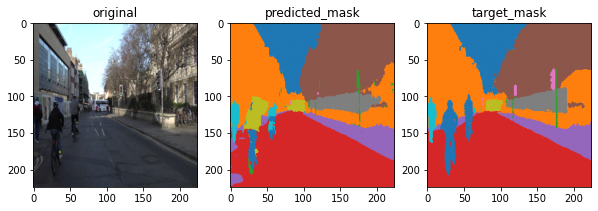

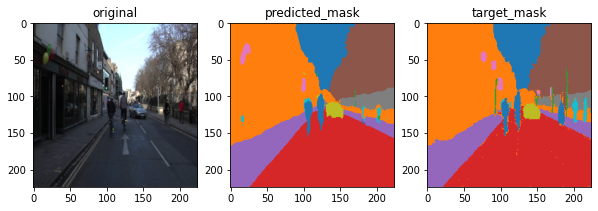

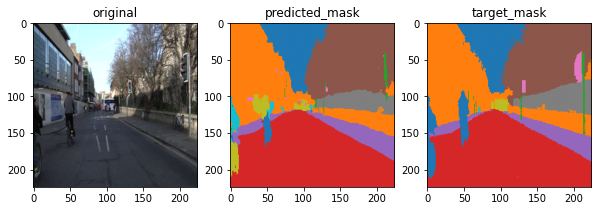

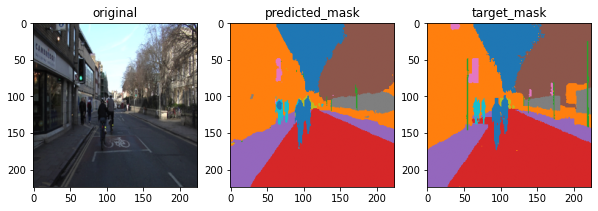

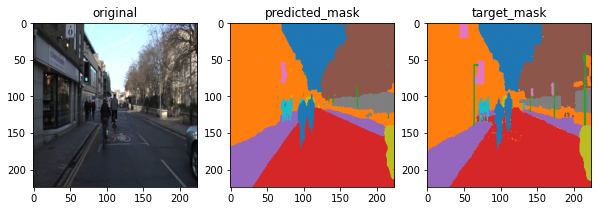

In [ ]:
# val_imagesからランダムに選んだ5枚を推論

for i in range(5):
    idx = np.random.choice(np.arange(0, 100, 1))
    
    # 読み込んだ画像の配列化
    origin = np.array(Image.open(val_images[idx]).resize((224, 224)))
    
    # 推論処理
    input_img = val[idx][0]
    input_img = input_img.unsqueeze(0).to(device)
    net.to(device).eval()
    pred = net(input_img)
    
    # 推論結果の後処理
    # plt.imshowを行うため、gpuからcpuへdetachする.
    
    pred_mask = torch.argmax(pred, 1)
    pred_mask = pred_mask.squeeze(0).cpu().detach().numpy()
    pred_mask = give_color(pred_mask, n_classes=12)
    
    # 教師データの読み込み
    target = val[idx][1]
    target_mask = give_color(target.numpy(), n_classes=12)
    
    # 可視化
    fig = plt.figure(figsize=(10, 30))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(origin)
    ax.set_title("original")
    
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(pred_mask)
    ax.set_title("predicted_mask")
    
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(target_mask)
    ax.set_title("target_mask")

# モデル/バックボーンネットワークの変更

- EncoderをVGG、Resnet等に変更して結果を確認する。
- 簡単な実装方法として、segmentation_models_pytorchがある.
- 参考URL: https://github.com/qubvel/segmentation_models.pytorch#architectures

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-gyt9ctf4
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-gyt9ctf4
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 1fa49d0953708c0a61ab11c5cc4052d20909a9bc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.0-py3-none-any.whl size=102059 sha256=340f2989725fdd9744760e6e732fd494805009652a948fc6a0f8e4df7431010e
  Stored in directory: /tmp/pip-ephem-wheel-cache-qv95d9uv/wheels/fa/c5

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
# resnet18バックボーンのUNet読み込み
unet = smp.Unet("resnet18", in_channels=3, classes=12, encoder_weights="imagenet")

unet

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
class Net_resnet18(pl.LightningModule):
    def __init__(self, in_channels=3, n_classes=12):
        super().__init__()
        
        self.unet = smp.Unet("resnet18", in_channels=in_channels, classes=n_classes, encoder_weights="imagenet")
        
    def forward(self, x):
        return self.unet(x)
    
    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        self.log("train_acc", accuracy(y.softmax(dim=1), t), on_step=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log("val_loss", loss, on_step=True, on_epoch=True)
        self.log("val_acc", accuracy(y.softmax(dim=1), t), on_step=True, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())
        

In [ ]:
pl.seed_everything(0)
net_resnet18 = Net_resnet18(n_classes=12)
trainer = pl.Trainer(max_epochs=30, gpus=1, deterministic=False)
trainer.fit(net_resnet18, train_loader, val_loader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
trainer.callback_metrics

{'train_loss': tensor(0.1522),
 'train_loss_step': tensor(0.1646),
 'train_acc': tensor(0.9473),
 'train_acc_step': tensor(0.9427),
 'val_loss': tensor(0.3340),
 'val_loss_epoch': tensor(0.3340),
 'val_acc': tensor(0.9008),
 'val_acc_epoch': tensor(0.9008),
 'train_loss_epoch': tensor(0.1522),
 'train_acc_epoch': tensor(0.9473)}

In [ ]:
# mIoUの算出

from torchmetrics.functional import jaccard_index

In [ ]:
y, t = predict(net_resnet18, val_loader, device="cpu")

print("pixel accuracy: ", accuracy(y, t))
print("IoU: ", jaccard_index(y, t, num_classes=12))

pixel accuracy:  tensor(0.9008)
IoU:  tensor(0.5828)


In [ ]:
class NetVgg16(pl.LightningModule):
    def __init__(self, in_channels=3, n_classes=12):
        super().__init__()
        
        self.unet = smp.Unet("vgg16", in_channels=in_channels, classes=n_classes, encoder_weights="imagenet")
        
    def forward(self, x):
        return self.unet(x)
    
    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        self.log("train_acc", accuracy(y.softmax(dim=1), t), on_step=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log("val_loss", loss, on_step=True, on_epoch=True)
        self.log("val_acc", accuracy(y.softmax(dim=1), t), on_step=True, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())
        

In [ ]:
pl.seed_everything(0)
net_vgg16 = NetVgg16(n_classes=12)
trainer = pl.Trainer(max_epochs=30, gpus=1, deterministic=False)
trainer.fit(net_vgg16, train_loader, val_loader)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
y, t = predict(net_vgg16, val_loader, device="cpu")

print("pixel accuracy: ", accuracy(y, t))
print("IoU: ", jaccard_index(y, t, num_classes=12))

pixel accuracy:  tensor(0.9063)
IoU:  tensor(0.6020)
